In [1]:
import re
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import sklearn.neighbors.kd_tree as kdtree

%matplotlib inline

In [2]:
df_all = pd.read_pickle('./data/df_all_lemma.pkl')
print(len(df_all))
df_all.head(1)

2524


,comments,description,duration,event,film_date,languages,link,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,transcript,url,views
0,4553.0,Sir Ken Robinson makes an entertaining and pro...,1164.0,TED2006,1.140826e+09,60.0,NaN,Ken Robinson,Ken Robinson: Do schools kill creativity?,1.0,1.151367e+09,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,it been great hasnt it. ive been blown away by...,https://www.ted.com/talks/ken_robinson_says_sc...,47227110.0


In [3]:
docs_all = list(df_all['transcript'])

from nltk.corpus import stopwords

stops_standard = stopwords.words('english')
stops_custom = ['shes','youll','ill','yeah','th','yes','oh',
                'ok','okay','might','ha','mr','bg','ms',
                'mrs','ca','em','da','ted','pm','hey','al']+[re.sub('[^A-Za-z ]+', '', w) for w in stops_standard]
stop_list = list(set(stops_standard + stops_custom))

print(stop_list)

['after', "hadn't", "hasn't", 'whom', 'more', "won't", 'herself', 'o', 'its', 'hasnt', 'havent', "don't", 'below', "mightn't", 'ha', 'al', 'yours', 'your', 'won', 'been', 'with', 'oh', 'because', 'only', 'at', 'mightn', 'i', 'but', 'during', 'd', "you've", 'out', "couldn't", 'above', 'into', 'weren', 'nor', 'can', 's', 'against', 'from', 'yourself', 'had', 'off', "aren't", 'mustn', 'am', 'dont', 'ourselves', 'yes', 'where', "you're", 'th', 'most', 'our', 'ma', 'same', 'shouldn', 'hadn', 'hey', 'why', 'my', 'having', 'there', 'so', 'mustnt', 'was', 'aren', 'on', 'do', 'wont', 'themselves', "should've", 'myself', 'her', 'all', 't', 'haven', "that'll", 'in', "it's", 'might', 'mrs', 'em', 'what', 'doing', 'she', 'not', 'the', 'he', 'to', 'too', "doesn't", 'hasn', 'by', 'have', "needn't", 'didnt', 'yourselves', "wouldn't", 'da', 'now', 'did', "she's", "weren't", "wasn't", 'theirs', 'mr', 'each', 'shouldnt', 'me', 'being', 'youve', 'arent', "isn't", 'hadnt', "you'll", 'just', 'pm', 'down', '

In [112]:
docs = docs_all

from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import Normalizer


n_samples = 2000
n_features = 2000
n_components = 50
n_top_words = 10
n_gram = 1
alpha = 0.1
stop_choice= stop_list

max_df = 0.3
min_df = 5
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


# Use tf-idf features for LSA.
print("Extracting tf-idf features for LSA...")
tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df,
                                   ngram_range=(n_gram,n_gram),
                                   max_features=n_features,
                                   stop_words=stop_choice)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(docs)
print("done in %0.3fs." % (time() - t0))

# Fit the LDA model
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lsa = TruncatedSVD(n_components=n_components, algorithm = 'randomized',random_state=1)
t0 = time()
lsa.fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LSA model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lsa, tfidf_feature_names, n_top_words)

Extracting tf-idf features for LSA...
done in 2.961s.
Fitting LDA models with tf features, n_samples=2000 and n_features=2000...
done in 0.238s.

Topics in LSA model:
Topic #0: city brain data water community design book company space computer
Topic #1: brain cell animal planet water cancer earth robot universe light
Topic #2: city water planet energy ocean earth climate space oil sea
Topic #3: cancer cell patient disease health drug government africa dollar data
Topic #4: data computer robot information machine company design internet government phone
Topic #5: city design cancer patient cell car architecture street neighborhood space
Topic #6: brain city neuron cortex memory region area neighborhood street activity
Topic #7: robot water animal food fish machine plant leg girl ocean
Topic #8: music sound song food play water africa plant business musician
Topic #9: music robot cell war cancer democracy government sound song political
Topic #10: music patient car sound universe health 

In [113]:
X = lsa.fit_transform(tfidf)
X = Normalizer(copy=False).fit_transform(X)


In [52]:
# X[1999].argmax()

In [111]:
# np.savetxt('./data/lsa_data_100.tsv', X, delimiter='\t',newline='\n')
# Xlabel = list(df_all.title)
# with open('./data/lsa_meta.tsv', 'w') as file:
#     for label in Xlabel:
#         file.write(label+'\n')

In [130]:
def save_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    return top_words

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
n_top_words = 10
LSA_top_words = save_top_words(lsa, tfidf_feature_names, n_top_words)

In [131]:
df = pd.DataFrame(LSA_top_words)
df.to_pickle('./data/LSA_top_words.pkl')
df.head()

,0,1,2,3,4,5,6,7,8,9
0,city,brain,data,water,community,design,book,company,space,computer
1,brain,cell,animal,planet,water,cancer,earth,robot,universe,light
2,city,water,planet,energy,ocean,earth,climate,space,oil,sea
3,cancer,cell,patient,disease,health,drug,government,africa,dollar,data
4,data,computer,robot,information,machine,company,design,internet,government,phone


### Find related talks

In [15]:
# import sklearn.neighbors.kd_tree as kdtree

In [142]:
tree = kdtree.KDTree(X, leaf_size=10) 
N = 2060
dist, ind = tree.query([X[N]], k=20)  
for i in ind[0]:
    print(i,'\t',df_all.iloc[i].title)
#     print(i,'\t',df_all.iloc[i].views)
#     print(df_all.iloc[i].tags)

2060 	 My year of saying yes to everything
2356 	 On tennis, love and motherhood
396 	 Play is more than just fun
344 	 The joyful tradition of mountain music
921 	 A manifesto for play, for Bulgaria and beyond
372 	 Fiddling in reel time
302 	 Lessons from past presidents
1484 	 In the key of genius
1715 	 Why I live in mortal dread of public speaking
273 	 Great piano performances, recreated
21 	 Nerdcore comedy
1459 	 Bluegrass virtuosity from ... New Jersey?
1317 	 Please don't take my Air Jordans
1392 	 Watson, Jeopardy and me, the obsolete know-it-all
1102 	 The clues to a great story
2377 	 How to find a wonderful idea
1205 	 A young guitarist meets his hero
2020 	 A beatboxing lesson from a father-daughter duo
639 	 Homeopathy, quackery and fraud
187 	 The untouchable music of the theremin


In [143]:
df_related = pd.DataFrame(eval(df_all.iloc[N]['related_talks']))
for k in range(len(df_related)):
    print(list(df_all[df_all['title']==df_related.iloc[k]['title']].title)[0])
#     print(df_all[df_all['title']==df_related.iloc[k]['title']].views)
#     print(list(df_all[df_all['title']==df_related.iloc[k]['title']].tags))

Your elusive creative genius
How to use data to make a hit TV show
Should you live for your résumé ... or your eulogy?
How to find a wonderful idea
Fashion and creativity
Play is more than just fun


In [50]:
# df_related

In [51]:
# df_all[df_all.main_speaker=='Rokia Traore']

In [118]:
def match_score(list1, list2):
    m = len(list1)
    score = 0
    matches = 0
    for title in list2:
        if title in list1:
            score += m - list1.index(title)
            matches += 1
    return (score, matches)

In [126]:
tree = kdtree.KDTree(X, leaf_size=10) 
scores = []
matches = []
for N in range(2467):
    # N = 1
    if N%100==0:
        print(N)
    dist, ind = tree.query([X[N]], k=20)  
    list1 = []
    for i in ind[0]:
        list1.append(df_all.iloc[i].title)
    list2 = []
    df_related = pd.DataFrame(eval(df_all.iloc[N]['related_talks']))
    for k in range(len(df_related)):
        items = list(df_all[df_all['title']==df_related.iloc[k]['title']].title)
        if len(items)>0:
            list2.append(items[0])
    scores.append(match_score(list1,list2)[0])
    matches.append(match_score(list1,list2)[1])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400


In [127]:
sum(scores)/2467 #28-20, 41-50, 46-75, 49-100, 49.32-120, 48.7-150, 45-200

41.80178354276449

In [128]:
sum(matches)/2467

3.0012160518848803

In [62]:
print([max_df,min_df,sum(scores)/2467])

[400, 10, 37.50547223348196]


In [58]:
print([max_df,min_df,sum(scores)/2467])

[500, 5, 39.41143088771788]


In [54]:
print([max_df,min_df,sum(scores)/2467])

[1000, 5, 41.67896230239157]


In [67]:
print([max_df,min_df,sum(scores)/2467])

[1000, 2, 41.72760437778678]


In [72]:
print([max_df,min_df,sum(scores)/2467])

[1500, 2, 41.3477908390758]


In [77]:
print([max_df,min_df,sum(scores)/2467])

[1500, 10, 41.19213619781111]


In [82]:
print([max_df,min_df,sum(scores)/2467])

[0.3, 5, 41.80178354276449]


### Clustering using KMeans

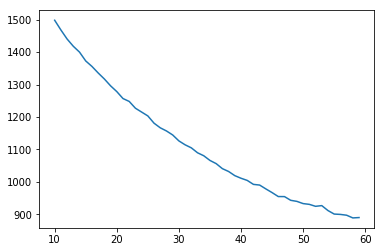

In [114]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn import cluster

n_clusters = 50

# ward = cluster.AgglomerativeClustering(
#     n_clusters=n_clusters, linkage='ward',
#     connectivity=connectivity)
# spectral = cluster.SpectralClustering(
#     n_clusters=n_clusters, eigen_solver='arpack',
#     affinity="nearest_neighbors")
# Xp = spectral.fit_predict(X)
# dbscan = cluster.DBSCAN(eps=params['eps'])

# km = KMeans(n_clusters=50)
# Xt = km.fit_transform(X)

# mu_docs = km.cluster_centers_
# plt.plot(mu_docs.transpose())

# silhouette_score(X, km.labels_, metric='euclidean')

sil_scores = []
iner_scores = []
ks = range(10,60)
for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sil_scores.append(silhouette_score(X, km.labels_, metric='euclidean'))
    iner_scores.append(km.inertia_)
    

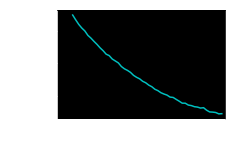

In [133]:
plt.figure(figsize=(3,2))
plt.plot(ks,iner_scores,'c')
plt.rcParams['axes.facecolor'] = 'black'

ax = plt.gca()
ax.set_xlabel('# OF CLUSTERS', fontsize=14, fontweight='bold')
ax.set_ylabel('INERTIA', fontsize=14, fontweight='bold')
ax.set_xlim([5,60])
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('k')
ax.xaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('k')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='y', colors='w')

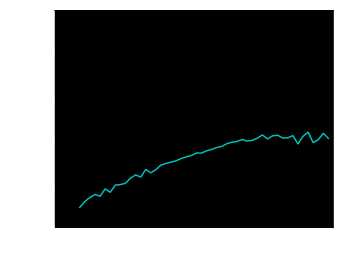

In [137]:
plt.figure(figsize=(5,4))
plt.plot(ks,sil_scores,'c')
plt.rcParams['axes.facecolor'] = 'black'

ax = plt.gca()
ax.set_xlabel('# OF CLUSTERS', fontsize=14, fontweight='bold')
ax.set_ylabel('SILHOUETTE', fontsize=14, fontweight='bold')
ax.set_xlim([5,60])
ax.set_ylim([0.05,0.3])

ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('k')
ax.xaxis.label.set_color('w')
ax.tick_params(axis='x', colors='w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('k')
ax.yaxis.label.set_color('w')
ax.tick_params(axis='y', colors='w')

In [505]:
tree = kdtree.KDTree(Xt, leaf_size=10) 
# N = 1346
dist, ind = tree.query([Xt[N]], k=10)  
for i in ind[0]:
    print(i,'\t',df_all.iloc[i].title)
#     print(i,'\t',df_all.iloc[i].views)
#     print(df_all.iloc[i].tags)

1599 	 Love -- you're doing it wrong
2343 	 3 ways to plan for the (very) long term
2085 	 How to get back to work after a career break
1395 	 What makes us feel good about our work?
1135 	 How I beat a patent troll
1872 	 How equal do we want the world to be? You'd be surprised
1821 	 The danger of hiding who you are
1870 	 5 ways to kill your dreams
1566 	 The $80 prosthetic knee that's changing lives
609 	 Plug into your hard-wired happiness


In [506]:
df_all.iloc[2343].transcript

'and theyd say great. and ive been seeing that time horizon get shorter and shorter and shorter so much so that i met with a ceo two month ago and i said we started our initial conversation. he go i love what you do. i want to talk about the next six month. we have a lot of problem that we are facing. these are civilizationalscale problem. the issue though is we cant solve them using the mental model that we use right now to try and solve these problem. yes a lot of great technical work is being done but there is a problem that we need to solve for a priori before if we want to really move the needle on those big problem. shorttermism. right. there no march. there no bracelet. there no petition that you can sign to be against shorttermism. i tried to put one up and no one signed. it wa weird. but it prevents u from doing so much. shorttermism for many reason ha pervaded every nook and cranny of our reality. i just want you to take a second and just think about an issue that youre think

In [40]:
df_all[df_all.title=='How to succeed? Get more sleep']

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
802,409,"In this short talk, Arianna Huffington shares ...",250,TEDWomen 2010,1291680000,57,Arianna Huffington,Arianna Huffington: How to succeed? Get more s...,1,1294066920,"[{'id': 3, 'name': 'Courageous', 'count': 216}...","[{'id': 70, 'hero': 'https://pe.tedcdn.com/ima...",Journalist,"['business', 'culture', 'entertainment', 'prod...",How to succeed? Get more sleep,https://www.ted.com/talks/arianna_huffington_h...,4241096,this is a room of type a woman. this is a room...
